# Topic Modeling and Latent Dirichlet Allocation (LDA)

Topic modeling is a common NLP task, which attempts to find the topics within a text document. Topic modeling is an unsupervised approach, and topic modeling only gives you an idea of which words frequently occur. It is then up to you to deduce the topic having seen the frequently and co-occurring words.

One of the primary applications of natural language processing is to automatically extract what topics people are discussing from large volumes of text. Some examples of large text could be feeds from social media, customer reviews of hotels, movies, etc, user feedbacks, news stories, e-mails of customer complaints etc.

Knowing what people are talking about and understanding their problems and opinions is highly valuable to businesses, administrators, political campaigns. And it’s really hard to manually read through such large volumes and compile the topics.

Thus is required an automated algorithm that can read through the text documents and automatically output the topics discussed.

In this tutorial, we will take a real example of the ’20 Newsgroups’ dataset and use LDA to extract the naturally discussed topics.

I will be using the Latent Dirichlet Allocation (LDA) from Gensim package along with the Mallet’s implementation (via Gensim). Mallet has an efficient implementation of the LDA. It is known to run faster and gives better topics segregation.

We will also extract the volume and percentage contribution of each topic to get an idea of how important a topic is. 


LDA’s approach to topic modeling is it considers each document as a collection of topics in a certain proportion. And each topic as a collection of keywords, again, in a certain proportion.

Once you provide the algorithm with the number of topics, all it does it to rearrange the topics distribution within the documents and keywords distribution within the topics to obtain a good composition of topic-keywords distribution.

When I say topic, what is it actually and how it is represented?

A topic is nothing but a collection of dominant keywords that are typical representatives. Just by looking at the keywords, you can identify what the topic is all about.

The following are key factors to obtaining good segregation topics:

    The quality of text processing.
    The variety of topics the text talks about.
    The choice of topic modeling algorithm.
    The number of topics fed to the algorithm.
    The algorithms tuning parameters.

<!-- For this exercise we use the news headlines published over a period of eighteen years from Australian sources ABC from [kaggle](https://www.kaggle.com/therohk/million-headlines/data) -->

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
# import pyLDAvis
# import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

## Data Pre-processing

In [35]:
data = pd.read_csv('data/abcnews-date-text.csv', error_bad_lines=False);
data_text = data[['headline_text']]
data_text['index'] = data_text.index
documents = data_text

In [37]:
data.head()

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers


In [36]:
print(len(documents))
print(documents[:5])

1226258
                                       headline_text  index
0  aba decides against community broadcasting lic...      0
1     act fire witnesses must be aware of defamation      1
2     a g calls for infrastructure protection summit      2
3           air nz staff in aust strike for pay rise      3
4      air nz strike to affect australian travellers      4


In [5]:
# Import Dataset
data = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')

In [6]:
data.shape

(11314, 3)

In [7]:
print(data.target_names.unique())

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


In [8]:
data.head()

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


In [9]:
# randomly select a subset
data = data.sample(n = 1000)

In [10]:
# Convert to list
data_text = data.content.values.tolist()

# Remove Emails
data_text = [re.sub('\S*@\S*\s?', '', sent) for sent in data_text]

# Remove new line characters
data_text = [re.sub('\s+', ' ', sent) for sent in data_text]

# Remove distracting single quotes
data_text = [re.sub("\'", "", sent) for sent in data_text]

In [11]:
pprint(data_text[:1])

['From: Followups-to: talk.politics.guns Subject: Re: ATF BURNS DIVIDIAN RANCH '
 '- UPDATE Distribution: usa Lines: 11 Ah yes, I see a few liberal weenies '
 'have come out of the woodwork to defend the burning of the children. '
 'Probably drooled all over themselves while watching the TV coverage. '
 'Probably had a few like that in Nazi Germany, as well. Oh yeah, ATF/FBI now '
 'claims, according the the media, that there are a few survivors. The number '
 'seems to vary minute by minute. ']


### Tokenize words and Clean-up text

Let’s tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.

Gensim’s simple_preprocess() is great for this. Additionally I have set deacc=True to remove the punctuations

In [13]:
# Initialize spacy language model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

#### Customized stop words

In [14]:
# New stop words list 
customize_stop_words = [
    'doi', 'preprint', 'copyright', 'org', 'https', 'et', 'al', 'author', 'figure', 'table', 'e-mail', 'file'
    'rights', 'reserved', 'permission', 'use', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier', 'PMC', 'CZI',
    '-PRON-', 'usually'
]

# Mark them as stop words
for w in customize_stop_words:
    nlp.vocab[w].is_stop = True

In [15]:
# check word frequencys
def spacy_tokenizer(sentence):
    return [word.lemma_ for word in nlp(sentence) if not (word.like_num or word.is_stop or word.is_punct or word.is_space or len(word)==1)]

In [16]:
vectorizer = CountVectorizer(tokenizer = spacy_tokenizer, min_df=2)
data_vectorized = vectorizer.fit_transform(data_text)

<AxesSubplot:ylabel='word'>

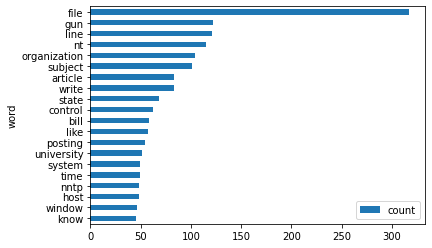

In [17]:
# most frequent words
word_count = pd.DataFrame({'word': vectorizer.get_feature_names(), 'count': np.asarray(data_vectorized.sum(axis=0))[0]})
word_count.sort_values('count', ascending=False).set_index('word')[:20].sort_values('count', ascending=True).plot(kind='barh')

In [18]:
# convert sentences to words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [19]:
data_words = list(sent_to_words(data_text))
print(data_words[:1])

[['from', 'followups', 'to', 'talk', 'politics', 'guns', 'subject', 're', 'atf', 'burns', 'dividian', 'ranch', 'update', 'distribution', 'usa', 'lines', 'ah', 'yes', 'see', 'few', 'liberal', 'weenies', 'have', 'come', 'out', 'of', 'the', 'woodwork', 'to', 'defend', 'the', 'burning', 'of', 'the', 'children', 'probably', 'drooled', 'all', 'over', 'themselves', 'while', 'watching', 'the', 'tv', 'coverage', 'probably', 'had', 'few', 'like', 'that', 'in', 'nazi', 'germany', 'as', 'well', 'oh', 'yeah', 'atf', 'fbi', 'now', 'claims', 'according', 'the', 'the', 'media', 'that', 'there', 'are', 'few', 'survivors', 'the', 'number', 'seems', 'to', 'vary', 'minute', 'by', 'minute']]


### Creating Bigram and Trigram Models

Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold. The higher the values of these param, the harder it is for words to be combined to bigrams.

In [20]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

In [21]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [22]:
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['from', 'followups', 'to', 'talk', 'politics', 'guns', 'subject_re', 'atf', 'burns', 'dividian', 'ranch', 'update', 'distribution_usa', 'lines', 'ah', 'yes', 'see', 'few', 'liberal', 'weenies', 'have', 'come', 'out', 'of', 'the', 'woodwork', 'to', 'defend', 'the', 'burning', 'of', 'the', 'children', 'probably', 'drooled', 'all', 'over', 'themselves', 'while', 'watching', 'the', 'tv', 'coverage', 'probably', 'had', 'few', 'like', 'that', 'in', 'nazi', 'germany', 'as', 'well', 'oh', 'yeah', 'atf', 'fbi', 'now', 'claims', 'according', 'the', 'the', 'media', 'that', 'there', 'are', 'few', 'survivors', 'the', 'number', 'seems', 'to', 'vary', 'minute', 'by', 'minute']


#### Remove Stopwords, Make Bigrams and Lemmatize

The bigrams model is ready. Let’s define the functions to remove the stopwords, make bigrams and lemmatization and call them sequentially.

In [23]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [24]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

In [25]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [26]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['followup', 'talk', 'politic', 'gun', 'atf', 'burn', 'dividian', 'ranch', 'update', 'distribution', 'usa', 'line', 'see', 'liberal', 'weenie', 'come', 'woodwork', 'defend', 'burn', 'child', 'probably', 'drool', 'watch', 'tv', 'coverage', 'probably', 'nazi', 'germany', 'atf', 'fbi', 'claim', 'accord', 'medium', 'survivor', 'number', 'seem', 'vary', 'minute', 'minute']]


#### Create the Dictionary and Corpus needed for Topic Modeling

The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus.  

Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on.

This is used as the input by the LDA model.

In [27]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1)]]


In [28]:
id2word[0]

'accord'

In [29]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('accord', 1),
  ('atf', 2),
  ('burn', 2),
  ('child', 1),
  ('claim', 1),
  ('come', 1),
  ('coverage', 1),
  ('defend', 1),
  ('distribution', 1),
  ('dividian', 1),
  ('drool', 1),
  ('fbi', 1),
  ('followup', 1),
  ('germany', 1),
  ('gun', 1),
  ('liberal', 1),
  ('line', 1),
  ('medium', 1),
  ('minute', 2),
  ('nazi', 1),
  ('number', 1),
  ('politic', 1),
  ('probably', 2),
  ('ranch', 1),
  ('see', 1),
  ('seem', 1),
  ('survivor', 1),
  ('talk', 1),
  ('tv', 1),
  ('update', 1),
  ('usa', 1),
  ('vary', 1),
  ('watch', 1),
  ('weenie', 1),
  ('woodwork', 1)]]

### Building the Topic Model

We have everything required to train the LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well.

Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.

chunksize is the number of documents to be used in each training chunk. update_every determines how often the model parameters should be updated and passes is the total number of training passes.

In [30]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

#### View the topics in LDA model

The above LDA model is built with 20 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

You can see the keywords for each topic and the weightage(importance) of each keyword using lda_model.print_topics() as shown next.

In [31]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.011*"selanne" + 0.009*"way" + 0.009*"see" + 0.009*"do" + 0.008*"trace" + '
  '0.008*"goal" + 0.006*"game" + 0.006*"line" + 0.006*"modem" + 0.006*"width"'),
 (1,
  '0.010*"line" + 0.009*"uranium" + 0.008*"write" + 0.008*"do" + '
  '0.008*"organization" + 0.007*"article" + 0.006*"receiver" + '
  '0.006*"university" + 0.005*"host" + 0.005*"nntp_poste"'),
 (2,
  '0.001*"file" + 0.000*"firearm" + 0.000*"gun" + 0.000*"get" + '
  '0.000*"gun_control" + 0.000*"article" + 0.000*"rkba" + 0.000*"bill" + '
  '0.000*"handgun" + 0.000*"mr"'),
 (3,
  '0.013*"line" + 0.013*"islander" + 0.011*"character" + 0.008*"truetype" + '
  '0.008*"font" + 0.008*"oem" + 0.008*"globe" + 0.008*"win" + 0.005*"get" + '
  '0.005*"set"'),
 (4,
  '0.014*"administration" + 0.013*"key" + 0.012*"inquiry" + 0.012*"security" + '
  '0.009*"chip" + 0.008*"eff" + 0.007*"organization" + 0.007*"issue" + '
  '0.007*"adopt" + 0.007*"escrow_agent"'),
 (5,
  '0.010*"get" + 0.009*"life" + 0.009*"organization" + 0.008*"vram" +

#### How to interpret this?

Topic 0 is a represented as _0.016“car” + 0.014“power” + 0.010“light” + 0.009“drive” + 0.007“mount” + 0.007“controller” + 0.007“cool” + 0.007“engine” + 0.007“back” + ‘0.006“turn”.

It means the top 10 keywords that contribute to this topic are: ‘car’, ‘power’, ‘light’.. and so on and the weight of ‘car’ on topic 0 is 0.016.

The weights reflect how important a keyword is to that topic.

Looking at these keywords, can you guess what this topic could be? You may summarise it either are ‘cars’ or ‘automobiles’.

Likewise, can you go through the remaining topic keywords and judge what the topic is?

#### Compute Model Perplexity and Coherence Score

Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. In my experience, topic coherence score, in particular, has been more helpful.

In [32]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -7.919194935792182


In [33]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3934252250309479


#### Visualize the topics-keywords

Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. There is no better tool than pyLDAvis package’s interactive chart and is designed to work well with jupyter notebooks.

In [34]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

NameError: name 'pyLDAvis' is not defined

So how to infer pyLDAvis’s output?

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

Alright, if you move the cursor over one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.

We have successfully built a good looking topic model.

Given our prior knowledge of the number of natural topics in the document, finding the best model was fairly straightforward.

Upnext, we will improve upon this model by using Mallet’s version of LDA algorithm and then we will focus on how to arrive at the optimal number of topics given any large corpus of text.